In [2]:
import pandas as pd
import numpy as np
df=pd.read_csv('/kaggle/input/google-stock-price/GOOG.csv')
df['New_Price'] = (df.splitFactor).replace(np.inf, 1).cumprod() * df.close
df['close'] = df['New_Price'] / 20



In [3]:
df.tail()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor,New_Price
1252,GOOG,2024-05-29 00:00:00+00:00,177.40,178.23,176.26,176.81,15023847,177.40,178.23,176.26,176.81,15023847,0.0,1.0,3548.0
1253,GOOG,2024-05-30 00:00:00+00:00,173.56,176.69,173.23,176.69,18844036,173.56,176.69,173.23,176.69,18844036,0.0,1.0,3471.2
1254,GOOG,2024-05-31 00:00:00+00:00,173.96,174.42,170.97,173.40,28085151,173.96,174.42,170.97,173.40,28085151,0.0,1.0,3479.2
1255,GOOG,2024-06-03 00:00:00+00:00,174.42,175.86,172.45,173.88,20742798,174.42,175.86,172.45,173.88,20742798,0.0,1.0,3488.4
1256,GOOG,2024-06-04 00:00:00+00:00,175.13,175.19,173.22,174.45,14066602,175.13,175.19,173.22,174.45,14066602,0.0,1.0,3502.6


In [4]:
df1=df.reset_index()['close']

In [5]:
df1.tail()

1252    177.40
1253    173.56
1254    173.96
1255    174.42
1256    175.13
Name: close, dtype: float64

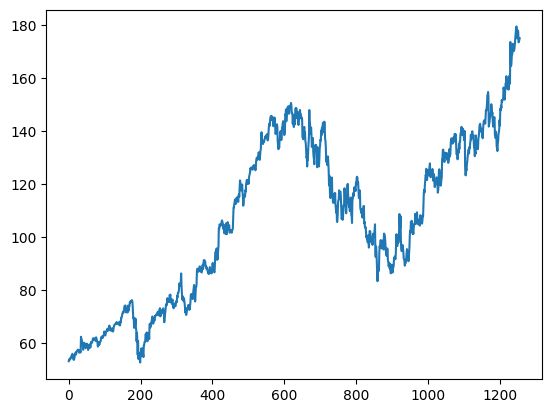

In [6]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [10]:
df1.shape

(1257, 1)

In [9]:
training_size=int(len(df1)*0.7)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [11]:
training_size,test_size

(879, 378)

In [14]:
train_data[:10]

array([[0.00371718],
       [0.00937581],
       [0.00872077],
       [0.00805389],
       [0.01268655],
       [0.011337  ],
       [0.01415843],
       [0.01853854],
       [0.01803739],
       [0.02162435]])

In [18]:
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [25]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [27]:
print(X_train.shape)
print(y_test.shape)

(778, 100)
(277,)


In [28]:
# need 3d model for stacked lstm
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [36]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input

In [45]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [46]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 100, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=20,batch_size=64,verbose=1)

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 194ms/step - accuracy: 9.1265e-04 - loss: 0.1048 - val_accuracy: 0.0036 - val_loss: 0.0400
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - accuracy: 0.0011 - loss: 0.0121 - val_accuracy: 0.0036 - val_loss: 0.0030
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - accuracy: 0.0036 - loss: 0.0049 - val_accuracy: 0.0036 - val_loss: 0.0032
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 4.8970e-04 - loss: 0.0021 - val_accuracy: 0.0036 - val_loss: 0.0033
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - accuracy: 2.7663e-04 - loss: 0.0016 - val_accuracy: 0.0036 - val_loss: 0.0039
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 4.8970e-04 - loss: 0.0017 - val_accuracy: 0.0036 - val_loss: 0.0035
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 9.1265e-04 - loss: 0.0017 - val_accuracy: 0.0036 - val_loss: 0.0033
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 3.7809e-04 - loss: 0

In [49]:
test_loss = model.evaluate(X_test, y_test, verbose=0)[0]

# Print the test loss
print("Test loss:", test_loss)

Test loss: 0.0019872502889484167


In [50]:
import pickle

# Save the model to a.pkl file
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)